# Fold arbitrary fluxes through MagEIS isotropic response functions

This notebook explores how to calculate flux as a function of energy. This method has the advantage that it does not depend on the spectral shape. 

The basic steps are: first create a fake true spectrum (exponential in this case, or hypothetically any other spectra). Then draw the observed counts from the true spectra. Next, we assume unifrom priors on the energy channel-dependent flux. This is where the "shape" kwarg comes in. This appears to be the best way (but perhaps not the only way) to create arrays of stocastic variables. Then we simply multiply the stocastic flux variables by their respective response functions to get counts. Lastly, we use MCMC to find the distribution of fluxes that best match the observed counts. 

TO-DO:
- Look into the unifrom prior assumption. Can we do better?
- Apply this algorithm to the MagEIS data to see how close these values are to the main rate data. Will need to use Seth's look up tables (LUTs) to determine which energy channels to use.
- Implement Brian's idea of using a histogram of fluxes with an arbitrary number of bins. Math question: Does having more flux bins than energy channels make any sense? It seems like we are interpolating and not gaining anything new from this.
- Lastly, I would like to use the Bayes factor to determine which spectra better fits the MagEIS data? Brian thinks there will be hardly any difference (|B factor| < 10ish) but who knows? If there are systematic trends, maybe a power law fits quiet time rad belt, while exponential fits interesting structures such as injections? Just a thought, but may be worth exploring to get at the underlying physics.

In [2]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Create a true exponential spectra with E0t and J0t parameters. 
Then use that spectra and fold it through the MagEIS response functions to get true counts as a function of energy channel.

In [3]:
# Spectra parameters
E0t = 100 # keV
J0t = 1E4 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP-A MagEIS LOW.
E = R.E*1000 # energy array in keV.
n_ch = 9 # Use the main rate channels

# Define an exponential spectra.
def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity in the response functions.
true_lambda = np.array([scipy.integrate.trapz(spectra(E, J0t, E0t)*R.response(i), x=E)
                       for i in range(n_ch)])

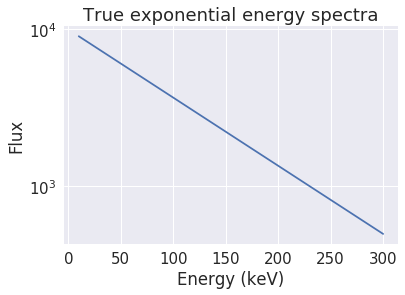

In [4]:
plt.plot(E, spectra(E, J0t, E0t)); plt.title('True exponential energy spectra')
plt.yscale('log'); plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

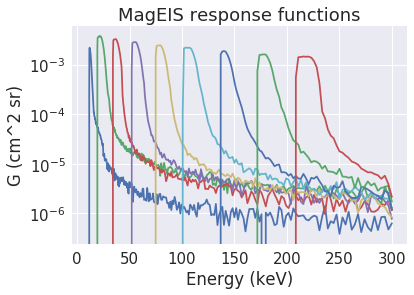

In [5]:
for i in range(n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');

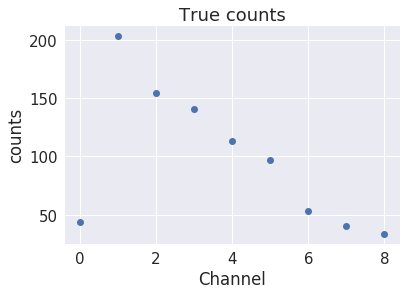

In [6]:
plt.plot(range(n_ch), true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now draw observed counts from true_lambda assuming a Poisson process

In [7]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

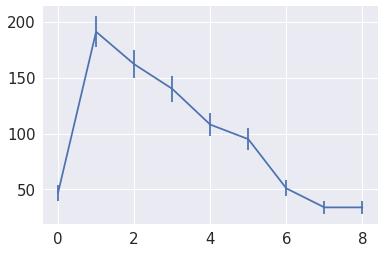

In [30]:
plt.errorbar(np.arange(len(c_obs)), c_obs, yerr=np.sqrt(c_obs));

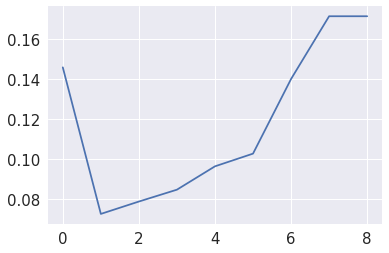

In [32]:
plt.errorbar(np.arange(len(c_obs)), np.sqrt(c_obs)/c_obs);

### Model the energy channel-dependent flux 

In [8]:
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    """
    # Numpy arrays do not work for this, but lists can store anything (sloppy).
    lams = n_ch*[0] 
    
    for ch in range(n_ch):
        # Fold the flux through R
        f = pm.math.dot(JJ[ch], R.response(ch))
        # Integrate over the folded spectra and keep an MCMC trace.
        lams[ch] = pm.Deterministic('lam{}'.format(ch), pymcTrapz(f, E))
    return lams

m = pm.Model()
with m:
    # Prior stocastic variables
    J = pm.Uniform('J', lower=1, upper=1E6, shape=n_ch)

    lams = lam(J) # Get the count values from the picked J array of values.
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [J_interval__]
 10%|▉         | 1015/10500.0 [00:05<00:52, 182.17it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '21607' (I am process '21608')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/msshumko/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-redhat-7.5-Maipo-x86_64-3.6.0-64/lock_dir
100%|██████████| 10500/10500.0 [01:05<00:00, 159.94it/s]


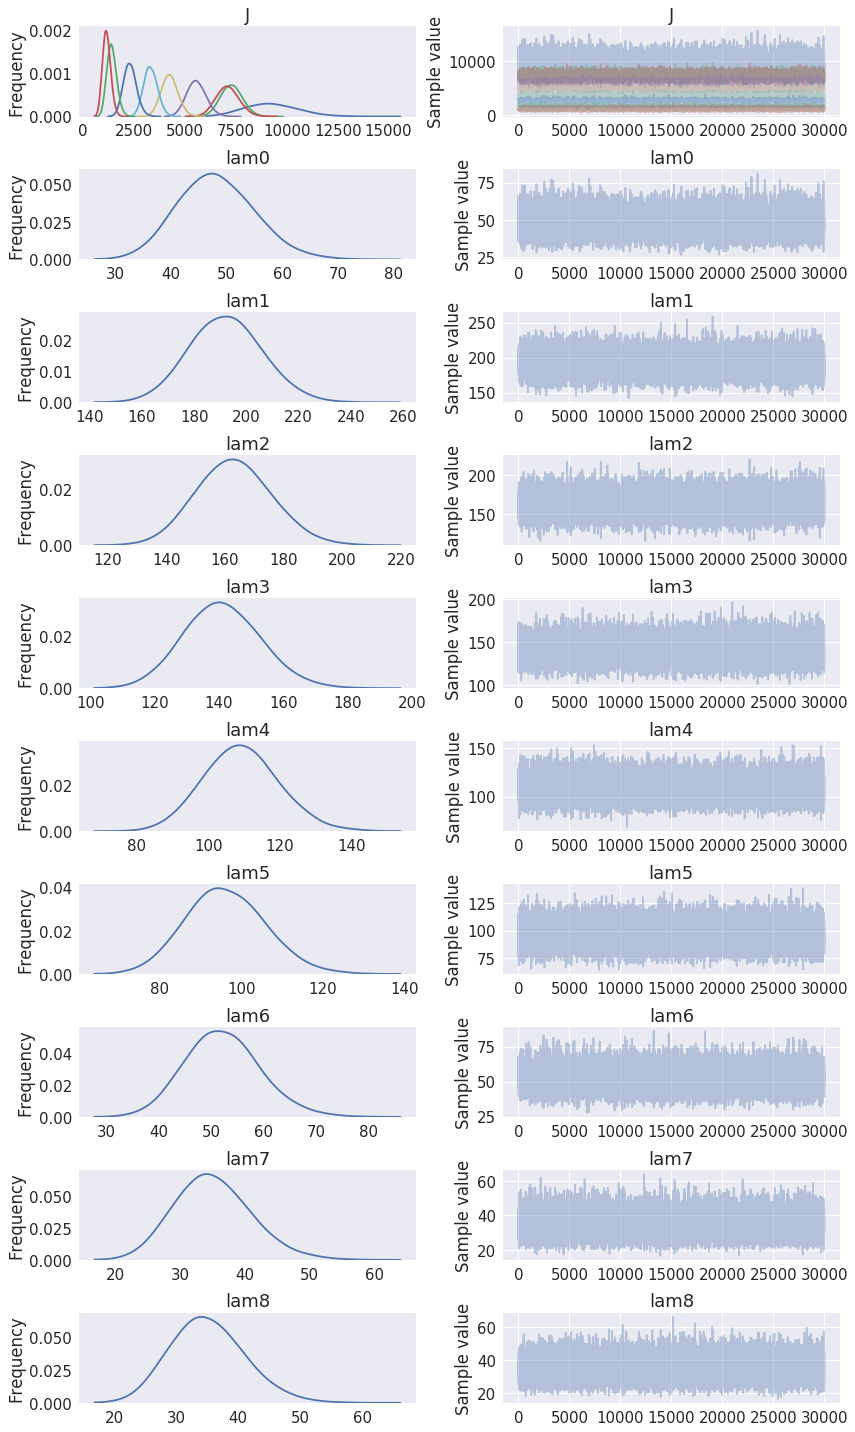

In [9]:
pm.traceplot(trace, combined=True);

In [10]:
pm.summary(trace)

mean           sd  mc_error      hpd_2.5      hpd_97.5  \
J__0  9222.871825  1313.122990  7.561145  6654.163382  11770.204664   
J__1  7277.644779   525.300287  2.968514  6287.852832   8338.562929   
J__2  7083.902853   555.637588  3.092289  6008.589102   8173.265721   
J__3  5552.907053   468.533160  2.645982  4641.373450   6475.134491   
J__4  4241.358603   404.632308  2.321657  3449.942485   5029.060171   
J__5  3312.855776   335.105487  1.972010  2676.370663   3984.178115   
J__6  2300.067024   317.014429  1.922344  1696.749519   2940.886603   
J__7  1407.672022   235.665988  1.233576   959.540940   1875.333197   
J__8  1156.326994   195.956026  0.991250   791.870394   1551.373830   
lam0    48.033764     6.838894  0.039379    34.655639     61.300563   
lam1   191.918603    13.852682  0.078283   165.816822    219.896051   
lam2   162.923466    12.779170  0.071120   138.192206    187.977843   
lam3   140.895339    11.888212  0.067137   117.766762    164.295253   
lam4   109.034896    10.402101  0.059684    88.689534    129.284765   
lam5    96.036663     9.714402  0.057167    77.585541    115.497684   
lam6    52.065150     7.176053  0.043515    38.408237     66.570974   
lam7    35.008056     5.860888  0.030678    23.863274     46.638542   
lam8    35.035212     5.937214  0.030034    23.992649     47.004620   

             n_eff      Rhat  
J__0  34087.542173  0.999971  
J__1  33086.666635  0.999986  
J__2  32933.316376  1.000043  
J__3  31343.565624  1.000027  
J__4  32463.830778  0.999955  
J__5  33792.462299  1.000136  
J__6  30071.007493  0.999978  
J__7  32300.410801  0.999980  
J__8  33491.289877  0.999969  
lam0  34087.542173  0.999971  
lam1  33086.666635  0.999986  
lam2  32933.316376  1.000043  
lam3  31343.565624  1.000027  
lam4  32463.830778  0.999955  
lam5  33792.462299  1.000136  
lam6  30071.007493  0.999978  
lam7  32300.410801  0.999980  
lam8  33491.289877  0.999969

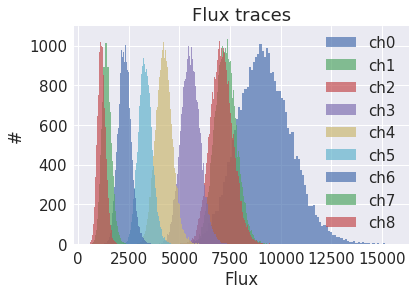

In [11]:
for ch in range(n_ch):
    plt.hist(trace['J'][:, ch], alpha=0.7, bins=100, label='ch{}'.format(ch))
plt.legend(); plt.title('Flux traces'); plt.ylabel('#'); plt.xlabel('Flux');

Now use the traces to calculate the modeled counts and uncertainties, as well as the flux means and stds.

In [12]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]

j_mean = np.mean(trace['J'], axis=0)
j_std = np.std(trace['J'], axis=0)

c_Err = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(len(c_obs))])

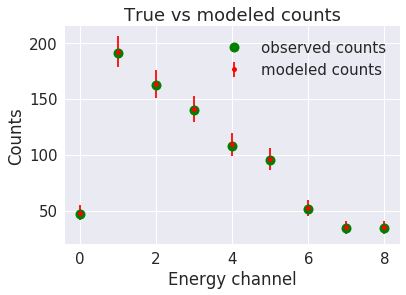

In [13]:
plt.plot(np.arange(n_ch), c_obs, 'go', label='observed counts', ms=10);
plt.errorbar(np.arange(n_ch), c_mean, fmt='ro', yerr=c_std, label='modeled counts', ms=5);
plt.legend(); plt.title('True vs modeled counts'); plt.xlabel('Energy channel');
plt.ylabel('Counts');

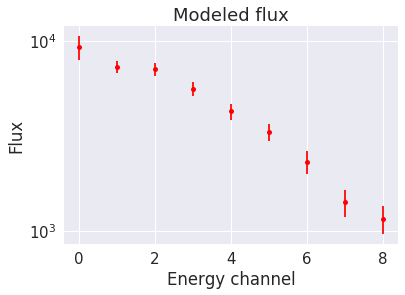

In [14]:
plt.errorbar(np.arange(n_ch), j_mean, fmt='ro', yerr=j_std, label='modeled flux', ms=5);
plt.title('Modeled flux'); plt.xlabel('Energy channel'); plt.ylabel('Flux');
plt.yscale('log')

In [15]:
#pm.plots.pairplot(trace);

### Now try to fit the flux to recover the exponential fit parameters

In [33]:
# Find the representative energy channel middles.
Ei = np.argmax([R.response(i) for i in range(n_ch)], axis=1)
E_mid = E[Ei]

In [22]:
E_mid

array([ 11.99618817,  21.42859626,  36.5749175 ,  55.08466767,
        79.27153944, 106.55224905, 139.9998402 , 177.77547349,
       215.70257433])

Now fit log(J) with a straight line

In [24]:
p = np.polyfit(E_mid, np.log(j_mean), 1)
print('Fit values: \nJ0 = {} [flux units], E0 = {} keV'.format(round(np.exp(p[1])), round(-1/p[0])))
print('True values: \nJ0 = {} [flux units], E0 = {} keV'.format(round(J0t), round(E0t)))
print('Relative error: JOerr = {} %, E0err = {} %'.format(
        round(100*(1-np.exp(p[1])/J0t)),
        round(100*(1+1/p[0]/E0t))))

Fit values: 
J0 = 9826.0 [flux units], E0 = 97.0 keV
True values: 
J0 = 10000 [flux units], E0 = 100 keV
Relative error: JOerr = 2.0 %, E0err = 3.0 %


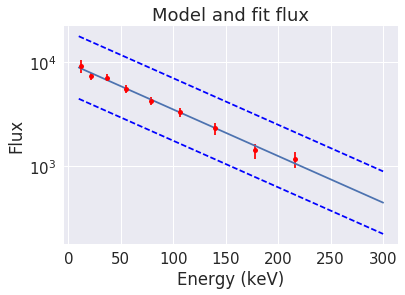

In [28]:
plt.errorbar(E_mid, j_mean, fmt='ro', yerr=j_std, label='modeled flux', ms=5);
# plt.plot(p[1]*np.exp(E/p[0])); #plt.yscale('log')
plt.plot(E, np.exp(p[1])*np.exp(p[0]*E));

plt.plot(E, np.exp(p[1])*np.exp(p[0]*E)/2, 'b--');
plt.plot(E, np.exp(p[1])*np.exp(p[0]*E)*2, 'b--');
plt.yscale('log'); plt.title('Model and fit flux'); 
plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

In [36]:
res = (j_mean - np.exp(p[1])*np.exp(p[0]*E[Ei]))

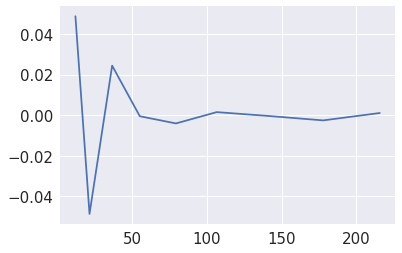

In [40]:
plt.plot(E[Ei], res/np.exp(p[1])*np.exp(p[0]*E[Ei]));